### Import All necessary modules

In [5]:
import time
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_validate
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score

#import deepcopy
from copy import deepcopy

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## read the data

In [6]:
df = pd.read_csv("cleaned_data.csv")
df.head()

,ID,text,label
0,7.680980e+17,josh jenkins loking forward tab breders crown ...,1
1,7.680980e+17,mianusmanjaved congratulations pakistan becomi...,1
2,7.680980e+17,pepalerts september yesmag taking maine mendoz...,1
3,7.680980e+17,davidgaibis newly painted wals thanks milion c...,1
4,7.680980e+17,cedricfeschote excited anounce july feschote l...,1


## Tokenize the data

In [7]:
df['tokens'] = df['text'].apply(lambda x: word_tokenize(x))
df.head()

,ID,text,label,tokens
0,7.680980e+17,josh jenkins loking forward tab breders crown ...,1,"[josh, jenkins, loking, forward, tab, breders,..."
1,7.680980e+17,mianusmanjaved congratulations pakistan becomi...,1,"[mianusmanjaved, congratulations, pakistan, be..."
2,7.680980e+17,pepalerts september yesmag taking maine mendoz...,1,"[pepalerts, september, yesmag, taking, maine, ..."
3,7.680980e+17,davidgaibis newly painted wals thanks milion c...,1,"[davidgaibis, newly, painted, wals, thanks, mi..."
4,7.680980e+17,cedricfeschote excited anounce july feschote l...,1,"[cedricfeschote, excited, anounce, july, fesch..."


## Lemmatization of tokens

In [8]:
lemmatizer = nltk.stem.WordNetLemmatizer()
df['lem'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['tokens'].head()

0    [josh, jenkins, loking, forward, tab, breders,...
1    [mianusmanjaved, congratulations, pakistan, be...
2    [pepalerts, september, yesmag, taking, maine, ...
3    [davidgaibis, newly, painted, wals, thanks, mi...
4    [cedricfeschote, excited, anounce, july, fesch...
Name: tokens, dtype: object

## Stemming of tokens

In [9]:
stemmer = nltk.stem.SnowballStemmer('english')
df['stem'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])
df['stem'].head()

0    [josh, jenkin, loke, forward, tab, breder, cro...
1    [mianusmanjav, congratul, pakistan, becom, not...
2    [pepalert, septemb, yesmag, take, main, mendoz...
3    [davidgaibi, newli, paint, wal, thank, milion,...
4    [cedricfeschot, excit, anounc, juli, feschot, ...
Name: stem, dtype: object

## Update the text column

In [10]:
df['text'] = df['tokens'].apply(lambda x: " ".join(x))
df['text'].head()

0    josh jenkins loking forward tab breders crown ...
1    mianusmanjaved congratulations pakistan becomi...
2    pepalerts september yesmag taking maine mendoz...
3    davidgaibis newly painted wals thanks milion c...
4    cedricfeschote excited anounce july feschote l...
Name: text, dtype: object

## Feature Extraction
### Function to convert the data into a matrix of TF-IDF features

In [114]:
def tfidf_vectorization(df_text, max_features = 50000):
  vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3),max_features = max_features)
  return vectorizer.fit_transform(df_text)

## xgboost (using default parameters)

In [124]:
X = tfidf_vectorization(df['text'])
y = df['label']

# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# train the model
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# predict
y_pred = xgb.predict(X_test)

# f1 score
print(f"f1_score: {f1_score(y_test, y_pred, average='weighted')}")

#accuracy
print(f"accuracy: {accuracy_score(y_test, y_pred)}")

f1_score: 0.9295327130975688
accuracy: 0.9284390557056166


## xgboost (adding basic assumed parameters)

In [115]:
X = tfidf_vectorization(df['text'])
y = df['label']

# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# train the model
xgb = XGBClassifier(n_estimators=300,
                    max_depth=30,
                    min_child_weight= 3,
                    gamma= 0.3,
                    subsample= 0.7,
                    colsample_bytree= 0.7,
                    reg_alpha= 0.5,
                    reg_lambda= 0.7,
                    scale_pos_weight= 3
                    )
xgb.fit(X_train, y_train)

# predict
y_pred = xgb.predict(X_test)

# f1 score
print(f"f1_score: {f1_score(y_test, y_pred, average='weighted')}")

#accuracy
print(f"accuracy: {accuracy_score(y_test, y_pred)}")

f1_score: 0.9657725820031434
accuracy: 0.9660606354243632


## Function to run XGBoost model
#### Grid Search, Random Search and Direct

In [131]:
def xgboost(df_text,df_label, param_grid, max_features= 20000, search= 'random'):

  # vectorizing
  vectorizer = TfidfVectorizer(max_features = max_features)
  X = vectorizer.fit_transform(df_text)
  y = df_label

  if search == 'random':
    xgb = XGBClassifier()
    xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    xgb_random.fit(X, y)
    print(xgb_random.best_params_)
    return xgb_random.cv_results_
  elif search == 'grid':
    print('~~ grid search started ~~')
    start = time.time()
    xgb = XGBClassifier()
    xgb_grid = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
    xgb_grid.fit(X, y)
    end = time.time()
    print(f"grid search took {end-start} seconds")
    return xgb_grid.cv_results_
  elif search == 'direct':
    start = time.time()
    print('~~ Starting process ~~')
    # split to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # train the model
    xgb = XGBClassifier(**param_grid)
    xgb.fit(X_train, y_train)
    # predict
    y_pred = xgb.predict(X_test)
    end = time.time()
    print(f"process finished, elapsed time: {end-start}")
    # f1 score
    return (f1_score(y_test, y_pred, average='weighted'), end-start)
    # return xgb


## feature selection

In [ ]:
max_features_list = [i for i in range(5000,55000,5000)]

params = {
    'max_depth': [10,20,30,40,50],
    'n_estimators': [100,200,300,400,500]
}

f1_scores_list = []

for x in range(5):
  f1_scores = []
  for i in max_features_list:
    X = vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3),max_features = i).fit_transform(df['text'])
    y = df['label']

    # split to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # train the model
    xgb = XGBClassifier(max_depth=params['max_depth'][x], n_estimators=params['n_estimators'][x])
    xgb.fit(X_train, y_train)

    # predict
    y_pred = xgb.predict(X_test)

    # f1 score
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
  f1_scores_list.append(f1_scores)
  print('score',x+1,'is:',f1_scores[x])

In [85]:
the_list = deepcopy(f1_scores_list)

In [84]:
# save the list to a text file
with open('f1_scores_list.txt', 'w') as f:
    for item in the_list:
        f.write("%s " % item)

Text(0, 0.5, 'f1_score')

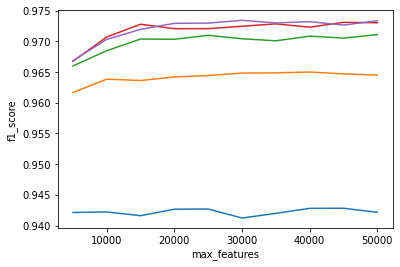

In [82]:
# plot for every list in f1_scores_list in single graph
plt.plot(max_features_list, the_list[0], label='max_depth=10, n_estimators=100')
plt.plot(max_features_list, the_list[1], label='max_depth=20, n_estimators=200')
plt.plot(max_features_list, the_list[2], label='max_depth=30, n_estimators=300')
plt.plot(max_features_list, the_list[3], label='max_depth=40, n_estimators=400')
plt.plot(max_features_list, the_list[4], label='max_depth=50, n_estimators=500')
plt.xlabel('max_features')
plt.ylabel('f1_score')


#### It's clear from above graph that anywhere from 10000 to 20000 features is enough.
#### Next we will do cross-validation to tune some hyper parameters using RandomGridCV

## Hyperparameter tuning

#### We will only be tuning the basic ones which have high impact to reduce the computation cost required

param_grid = {
  
      'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
      'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
      'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
      'min_child_weight': [1, 2, 3, 4, 5],
      'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
      'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
      'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
      'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
      'reg_lambda': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
      'scale_pos_weight': [1, 2, 3, 4, 5]
    }

### max_depth hyperparameter tuning

Fitting 3 folds for each of 6 candidates, totalling 18 fits


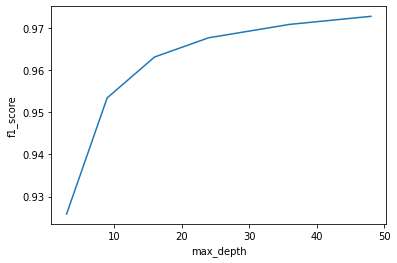

In [11]:
param_grid = {
      'max_depth': [3, 9, 16, 24, 36, 48]
    }

gscv = xgboost(df['text'], df['label'], param_grid, max_features= 20000)

# plot a graph for max_depth vs f1_score
plt.plot(gscv['param_max_depth'], gscv['mean_test_score'])
plt.xlabel('max_depth')
plt.ylabel('f1_score')
plt.show()

### n_estimators hyperparameter tuning

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 500}


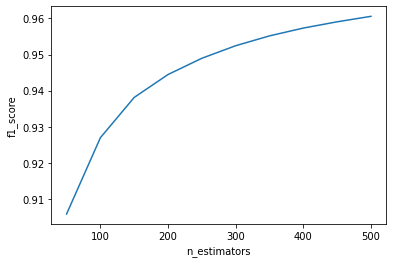

In [13]:
param_grid = {
      'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    }

gscv = xgboost(df['text'], df['label'], param_grid, max_features= 20000, search= 'grid')

# plot a graph for n_estimators vs f1_score
plt.plot(gscv['param_n_estimators'], gscv['mean_test_score'])
plt.xlabel('n_estimators')
plt.ylabel('f1_score')
plt.show()

#### Let's use max_depth as 50 and n_estimators as 500 and check for computational costs and f1_score at different number of features

In [37]:

param_grid = {
    'max_depth' : 50,
    'n_estimators' : 500
}

max_features = [1000, 5000, 10000, 15000, 20000, 25000, 30000]
f1_scores = []
times = []
for max_feature in max_features:
    f1_scorex, timex = xgboost(df['text'], df['label'], param_grid, max_features= max_feature, search= 'direct')
    f1_scores.append(f1_scorex)
    times.append(timex)    

Starting process: 1
process: 1 time: 541.089715719223
Starting process: 1
process: 1 time: 686.5521483421326
Starting process: 1
process: 1 time: 723.4952147006989
Starting process: 1
process: 1 time: 794.2526729106903
Starting process: 1
process: 1 time: 727.7339761257172
Starting process: 1
process: 1 time: 754.8569893836975
Starting process: 1
process: 1 time: 821.1140558719635


In [38]:
# plot a graph for max_features vs f1_score
fig = px.line(x=max_features, y=f1_scores, title='max_features vs f1_score')
fig.show()

In [67]:
max_depths = [3, 24, 36, 48, 64, 72, 100]

f1_scores = []
times = []
for max_depth in max_depths:
    score = xgboost(df['text'], df['label'], param_grid={'max_depth': max_depth}, max_features= 10000, search= 'direct')
    f1_scores.append(score[0])
    times.append(score[1])

In [68]:
# plot a line graph for max_depth vs f1_score
fig = px.line(x=max_depths, y=f1_scores, title='max_depth vs f1_score', labels={'x':'max_depth', 'y':'f1_score'})
fig.show()

### Scale_pos_weight
#### Used to tune unbalanced dataset

In [127]:
# plot a bar graph of 1s and 0s in label column
fig = px.bar(df['label'].value_counts(), title='1s and 0s in label column')
fig.show()

##### we have more 1's than 0's, i.e more positive and therefore unbalanced, scale_pos_weight helps us here.

scale_pos_weight = sum(negative instances)/sum(positive instances)

In [128]:
scale_pos_weight = df['label'].value_counts()[0]/df['label'].value_counts()[1]
scale_pos_weight

0.482171373481517

## overfitting or underfitting

### max_depth

In [103]:
max_depths = [3, 16, 25 ,32, 54, 72, 100]

train_scores, test_scores = list(), list()

for i in max_depths:
  param_grid = {
      'max_depth' : i,
      'n_estimators' : 100
  }
  X = TfidfVectorizer(use_idf=True,ngram_range=(1,3),max_features = i).fit_transform(df['text'])
  y = df['label']

  # split to train and test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  # train the model
  xgb = XGBClassifier(**param_grid)
  xgb.fit(X_train, y_train)

  # evaluate on train set
  y_pred = xgb.predict(X_train)
  train_acc = accuracy_score(y_train, y_pred)
  train_scores.append(train_acc)

  # evaluate on test set
  y_pred = xgb.predict(X_test)
  test_acc = accuracy_score(y_test, y_pred)
  test_scores.append(test_acc)

  print('-> %d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))


-> 3, train: 0.676, test: 0.671
-> 16, train: 0.694, test: 0.694
-> 25, train: 0.729, test: 0.724
-> 32, train: 0.743, test: 0.739
-> 54, train: 0.788, test: 0.770
-> 72, train: 0.790, test: 0.772
-> 100, train: 0.837, test: 0.808


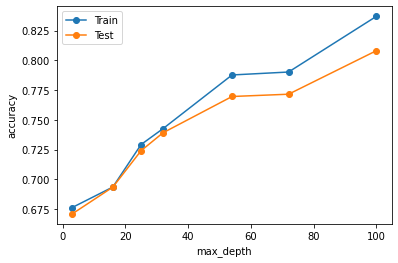

In [104]:
# plot of train and test scores vs max_depth
plt.plot(max_depths, train_scores, marker='o', label='Train')
plt.plot(max_depths, test_scores, marker='o', label='Test')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### n_estimators

In [101]:
n_estimators = [10, 20, 50, 75, 100, 250, 500, 750]

train_scores, test_scores = list(), list()

for i in n_estimators:
    param_grid = {
        'n_estimators' : i
    }
    X = TfidfVectorizer(use_idf=True,ngram_range=(1,3),max_features = 10000).fit_transform(df['text'])
    y = df['label']
    
    # split to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # train the model
    xgb = XGBClassifier(**param_grid)
    xgb.fit(X_train, y_train)
    
    # evaluate on train set
    y_pred = xgb.predict(X_train)
    train_acc = accuracy_score(y_train, y_pred)
    train_scores.append(train_acc)
    
    # evaluate on test set
    y_pred = xgb.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_scores.append(test_acc)
    
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))



>10, train: 0.768, test: 0.766
>20, train: 0.854, test: 0.854
>50, train: 0.905, test: 0.904
>75, train: 0.920, test: 0.920
>100, train: 0.931, test: 0.927
>250, train: 0.953, test: 0.948
>500, train: 0.966, test: 0.960
>750, train: 0.972, test: 0.964


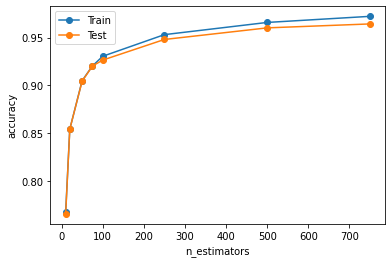

In [102]:
# plot of train and test scores vs n_estimators
plt.plot(n_estimators, train_scores, marker='o', label='Train')
plt.plot(n_estimators, test_scores, marker='o', label='Test')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Final Model

##### we can see that there is huge improvement in f1_score and accuracy as we go to around 100 in max_depth and similarly 500 for n_estimators but thy come with huge computational cost and greater chance of over-fitting.

##### looking at accuracy scores for training and testing data for parameters, we can take max_depth to be ~25 where it starts over-fitting,

#### similarly n_estimators to be 100 where difference between train and test accuracy starts increasing.

In [139]:
# run the model for max_depth = 50, n_estimators = 50, max_features = 10000
param_grid = {
    'max_depth' : 25,
    'n_estimators' : 100,
    'min_child_weight': 3,
    'subsample' : 0.5,
    'scale_pos_weight' : scale_pos_weight
}

# k-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
model = XGBClassifier(**param_grid)
print('~~ K-Fold Cross Validation started ~~')
start = time.time()
results = cross_validate(model, X, y, cv=kfold, scoring=('accuracy', 'f1', 'precision', 'recall'))
end = time.time()
print('Time taken for completion: ', end-start)
print('Accuracy: ', results['test_accuracy'].mean())
print('F1 Score: ', results['test_f1'].mean())
print('Precision: ', results['test_precision'].mean())
print('Recall: ', results['test_recall'].mean())

~~ K-Fold Cross Validation started ~~
Time taken for completion:  208.2200608253479
Accuracy:  0.9480551086081619
F1 Score:  0.960534628927568
Precision:  0.985357879718815
Recall:  0.9369313755280577


<h2 style="padding: 20px;color: #50C878; border: 1px solid #50C878; border-radius: 7px;">As we can see the scores are improved compared to when we did use only default parameters</h2>

## Save the model

In [199]:
X = tfidf_vectorization(df['text'], max_features=10000)
y = df['label']

# save the model by fitting it on train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = XGBClassifier(**param_grid)
model.fit(X_train, y_train)

# save the model
pickle.dump(model, open('model.pkl', 'wb'))

## Predict a sentence using model

In [202]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

test_sentence = "this is bad scam and fraud"

# load_model and predict test_sentence
loaded_model = pickle.load(open('xgboost_model.pkl', 'rb'))
loaded_model.fit(X_train, y_train)
# copy df['text'] to df['text_copy']
df['text_copy'] = df['text'].copy()
# replace first row of df['text_copy'] with test_sentence
df['text_copy'][0] = test_sentence
# transform df['text_copy'] using TfidfVectorizer
test_sentence = TfidfVectorizer(use_idf=True,ngram_range=(1,3),max_features = 10000).fit_transform(df['text_copy'])

#make X same size as X_train
test_sentence = test_sentence[0:X_train.shape[0]]

pred = model.predict(test_sentence)[0]
print(pred)

0
